# Execution Interval Method

In [1]:
import json
import os
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict
from libraries.utils import *
from libraries.exeint import exeInt




## Load Data

In [2]:
############ configuration ################
############################################

CODE = 'mamba2'       ### application (code)
BEHAVIOUR_FAULTY = 'faulty_data'            ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'            ### normal, faulty_data
THREAD = 'single'           ### single, multi
VER = 3                     ### format of data collection

base_dir = '../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print(normalbase_path)
print(faultybase_path)

../trace_data/mamba2/single_thread/version_3/normal
../trace_data/mamba2/single_thread/version_3/faulty_data


In [3]:

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = os.listdir(normalbase_path)
train_varlist_path = [os.path.join(normalbase_path, x) for x in train_varlist_path if 'varlist' in x]

######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

### remove.Ds_store from all lists
train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

# print(paths_log)
# print(paths_traces)
# print(varlist_path)
# print(paths_label)

test_data_path = paths_traces
test_label_path = paths_label

print(train_data_path)
print(test_data_path)
print(test_label_path)


['../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_8260_11000.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_0_6200.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_6500_9910.json', '../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_0_8260.json']
['../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial1', '../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial2', '../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial3', '../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial4']
['../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json', '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json', '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json', '../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_tri

In [4]:
varlist_path

['../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial1.json',
 '../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial2.json',
 '../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial3.json',
 '../trace_data/mamba2/single_thread/version_3/faulty_data/varlist_trial4.json']

In [5]:
############# check varlist is consistent ############
############# only for version 3 ######################

if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]]+ varlist_path) ### compare with train varlist

    if check_con != False:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        ### load normal varlist
        print('loading normal varlist')
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)



varlist 1 is consistent with varlist 0
varlist 2 is not consistent varlist 0
varlist 3 is consistent with varlist 0
varlist 4 is not consistent varlist 0
loading normal varlist


In [6]:
#### key finder ####
from_number[44]

'0-0-0-CONNECTION_VAR'

In [7]:
############ Get variable list ######################
sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]   ### get the variable list
# print(var_list)

## Confidence Interval

__Confidence Interval:__

A confidence interval is a range around the mean that is likely to contain the true population mean. The formula for a confidence interval is mean ± margin of error mean±margin of error, where the margin of error depends on the desired confidence level and the standard error.

_Example:_

1. Choose a confidence level (e.g., 95%).
2. Calculate the standard error: standard deviation/ sqr_root(number of observations)
3. Calculate the margin of error: critical value × standard error
4. Determine the confidence interval: mean ± margin of error


In [8]:
### initialize exeinz
ei = exeInt()

### Data Processing

In [9]:
### get execution intervals for all variables

exe_list, filewise_exe_list = ei.get_exeint(train_data_path)

../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_8260_11000.json
../trace_data/mamba2/single_thread/version_3/normal/train_data/interval_8260_11000.json
dict_keys([56, 57, 67, 23, 24, 49, 50, 31, 53, 54, 55, 58, 59, 20, 21, 22, 60, 61, 62, 63, 64, 65, 66, 70, 68, 69, 51, 26, 71, 72, 73, 27, 52, 28, 29])
56 449171 449951
56 449951 449992
56 449992 450807
56 450807 451587
56 451587 452366
56 452366 453145
56 453145 453187
56 453187 454002
56 454002 454781
56 454781 455561
56 455561 456340
56 456340 456534
56 456534 457350
56 457350 458129
56 458129 458909
56 458909 459688
56 459688 459730
56 459730 460545
56 460545 461324
56 461324 462104
56 462104 462883
56 462883 462928
56 462928 463743
56 463743 464523
56 464523 465302
56 465302 466081
56 466081 466124
56 466124 466938
56 466938 467717
56 467717 468496
56 468496 469276
56 469276 469321
56 469321 470137
56 470137 470916
56 470916 471695
56 471695 472475
56 472475 472518
56 472518 473332
56 473332 474112
56 474112

In [10]:
for k in list(exe_list.keys()):
    print(k, len(exe_list[k]))

56 1741
57 2791
67 344
23 1393
24 1393
49 4890
50 1045
31 347
53 347
54 347
55 347
58 346
59 346
20 346
21 346
22 346
60 346
61 1046
62 346
63 346
64 345
65 345
66 345
70 93
68 31
69 31
51 32
26 32
71 30
72 30
73 69
27 66
52 100
28 21
29 21
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
25 3
30 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3


In [11]:
################## methods to detect outliers based on execution intervals ####################

############ calculate dynamic thresholds ############
thresholds = ei.get_dynamicthresh(exe_list)

############ train lof model ################
lof_models = ei.train_lof(exe_list)

######### save thresholds and lof models ############
### visualize the thresholds for varlist
thresholds_var = {}
for key in thresholds.keys():
    thresholds_var[from_number[key]] = thresholds[key]

assert len(thresholds_var) == len(thresholds)
thresholds_var
save_json(thresholds_var, os.path.join(faultybase_path, 'thresholds.json'))

56
value: 0.8 prob: 0.8001148765077541
value: 0.0 prob: 0.1688684663986215
value: 0.1 prob: 0.010913268236645606
value: 0.2 prob: 0.020103388856978748
57
value: 0.8 prob: 0.48620566105338586
value: 0.0 prob: 0.5012540308133285
value: 1.0 prob: 0.012540308133285561
67
value: 3.4 prob: 0.10174418604651163
value: 3.2 prob: 0.8982558139534884
23
value: 0.9 prob: 0.20531227566403445
value: 0.8 prob: 0.7681263460157932
value: 1.1 prob: 0.0014357501794687725
value: 1.0 prob: 0.02512562814070352
24
value: 0.9 prob: 0.20531227566403445
value: 0.8 prob: 0.7681263460157932
value: 1.1 prob: 0.0014357501794687725
value: 1.0 prob: 0.02512562814070352
49
value: 0.0 prob: 0.6437627811860941
value: 0.8 prob: 0.2850715746421268
value: 0.1 prob: 0.0640081799591002
value: 0.2 prob: 0.007157464212678937
50
value: 0.0 prob: 0.6679425837320574
value: 3.2 prob: 0.2985645933014354
value: 3.3 prob: 0.03349282296650718
31
value: 3.4 prob: 0.09798270893371758
value: 3.5 prob: 0.005763688760806916
value: 3.2 prob:

In [12]:
thresholds_var

{'0-0-0-j': [0.0, 0.9],
 '0-0-0-func_call': [0.0, 1.1],
 '0-0-measure_am4-0': [3.1, 3.5],
 '0-0-0-am_temp': [0.7, 1.2],
 '0-0-0-am_hum': [0.7, 1.2],
 '0-0-0-SENSOR_DATA': [0.0, 0.9],
 '0-0-0-msg': [0.0, 3.4],
 '0-0-crc32-crc': [3.1, 3.6],
 '0-0-0-current_time': [3.1, 3.5],
 '0-0-0-SENSOR_STATUS': [3.1, 3.5],
 '0-0-0-LIMITS_BROKEN': [3.1, 3.5],
 '0-0-measure_scd30-0': [3.1, 3.5],
 '0-0-0-reading_co2': [3.1, 3.5],
 '0-0-0-scd_co2': [3.1, 3.6],
 '0-0-0-scd_temp': [3.1, 3.6],
 '0-0-0-scd_hum': [3.1, 3.6],
 '0-0-measure_co-0': [3.1, 3.5],
 '0-0-0-var': [0.0, 3.5],
 '0-0-measure_o2-0': [3.1, 3.5],
 '0-0-measure_bmp-0': [3.1, 3.5],
 '0-0-measure_am1-0': [3.1, 3.5],
 '0-0-measure_am2-0': [3.1, 3.5],
 '0-0-measure_am3-0': [3.1, 3.5],
 '0-0-cb_lora-rcv_msg': [0.0, 38.5],
 '0-0-cb_30-cb_30_done': [20.1, 38.8],
 '0-0-add_to_que-que': [22.4, 38.6],
 '0-0-0-start_time': [22.4, 38.6],
 '0-0-0-cb_30_done': [22.4, 38.6],
 '0-0-cb_lora-board_id': [22.2, 42.5],
 '0-0-cb_lora-timestamp': [22.2, 42.5],
 '0

In [13]:
lof_models

{56: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 57: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 67: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 23: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 24: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 49: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 50: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 31: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 53: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 54: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 55: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 58: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 59: LocalOutlierFactor(contamination=0.01, n_neighbors=2, novelty=True),
 20: LocalOutlierFactor(contamination=

### Visualising Thresholds

In [14]:
### plot exe_list to vsiualize the distribution of execution intervals
# ei.viz_thresholds(exe_list, thresholds=thresholds)


### Validation

In [15]:
#### Detect anomalies in faulty traces
DIFF_VAL = 2
all_tp = []
all_fp = []
all_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]  
all_group_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]
all_merged_detections = [] ### format [file1_detection, file2_detection] -> file1_detection: [(state1, 0), (ts1, ts2), filename]
y_pred_all = []
y_true_all = []
for test_data, test_label in zip(test_data_path, test_label_path):
    print(test_data, test_label)

    detection = ei.test_single(test_data, thresholds=thresholds)   ### detection in format: [var, (ts1,ts2), file_name]     ### threshold based detection
    # detection = ei.test_single(test_data, lof_models=lof_models)   ### detection in format: [var, (ts1,ts2), file_name]    ### lof based detection

    merged_detection, grouped_det = ei.merge_detections(detection, DIFF_VAL)  ### merge detections for multiple variables
    detection = merged_detection
    # dedup_detection, grouped_det = ei.remove_duplicates(detection, DIFF_VAL)  ### remove multiple detections for single ground truth
    # detection = dedup_detection

    all_detections += [(test_data, detection, test_label)]  ### used to plot detections
    all_group_detections += [(test_data, grouped_det, test_label)]  ### used to plot grouped detections
    # all_merged_detections += [(test_data, merged_detection, test_label)]  ### used to plot merged detections

    ### load ground truths
    ground_truth_raw = read_traces(test_label)
    ground_truth = ground_truth_raw['labels']
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]
    print('ground truths:', ground_truth)
    print(len(ground_truth))

    # correct_pred, rest_pred, y_pred, y_true = get_ypred_ytrue(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred
    correct_pred, rest_pred, y_pred, y_true = ei.get_correct_detections(detection, ground_truth)  ### case1_pred, case2_pred, case34_pred, rest_pred

    assert( len(detection) == len(correct_pred) + len(rest_pred) )

    all_tp += [(test_data, correct_pred, test_label)]
    all_fp += [(test_data, rest_pred, test_label)]

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)

    # break

../trace_data/mamba2/single_thread/version_3/faulty_data/trace_trial1 ../trace_data/mamba2/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json
Anomaly detected for 70 in trace_trial1 at 3884th event
Execution interval: 61.3
Anomaly detected for 71 in trace_trial1 at 3885th event
Execution interval: 61.3
Anomaly detected for 72 in trace_trial1 at 3886th event
Execution interval: 61.3
Anomaly detected for 71 in trace_trial1 at 4062th event
Execution interval: 9.8
Anomaly detected for 72 in trace_trial1 at 4063th event
Execution interval: 9.8
Anomaly detected for 70 in trace_trial1 at 5238th event
Execution interval: 42.0
Anomaly detected for 71 in trace_trial1 at 5588th event
Execution interval: 19.4
Anomaly detected for 72 in trace_trial1 at 5589th event
Execution interval: 19.4
Anomaly detected for 28 in trace_trial1 at 6559th event
Execution interval: 81.0
Anomaly detected for 29 in trace_trial1 at 6560th event
Execution interval: 81.0
Anomaly detected for 71 in trace_

Precision: 0.6081
Recall: 0.9783
F1 Score: 0.7500
Confusion Matrix:
[[ 0 29]
 [ 1 45]]


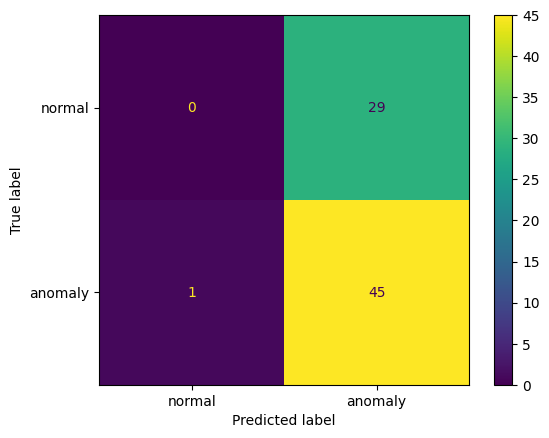

In [16]:
### Evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, average_precision_score, ConfusionMatrixDisplay


# Calculate precision
precision = precision_score(y_true_all, y_pred_all)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_true_all, y_pred_all)
print(f'Recall: {recall:.4f}')

# # Calculate average precision
# average_precision = average_precision_score(y_true_all, y_pred_all)
# print(f'Average Precision: {average_precision:.4f}')

# Calculate F1 score
f1 = f1_score(y_true_all, y_pred_all)
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:")
print(conf_matrix)
if len(conf_matrix) == 1:
    conf_matrix = np.array([[0, 0], [0, conf_matrix[0][0]]])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['normal', 'anomaly'])
disp.plot()

## Save Detections

In [17]:
######## save detections for the dashboard to plot #############
import traceback

for test_data, detections, test_label in all_detections:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'ei_detections')
    tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
    fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:
        with open(detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {detection_path}')

            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_tp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'ei_detections')
    tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
    fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(tp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {tp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_fp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'ei_detections')
    tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
    fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(fp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {fp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial1_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial2_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial3_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial4_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial1_tp_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial2_tp_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial3_tp_ei_detections.json
Saved detections in ../trace_data/mamba2/single_thread/version_3/faulty_data/ei_detections/trace_trial4_tp_ei_detections.json
Save

In [18]:
print('Total Detections:', len(all_detections[1][1]))
print('Total Groups:', len(all_group_detections[1][1]))
i=0
for item in all_group_detections[1][1]:
    for ind_item in item:
        i+=1
print('Detections in Groups:', i)
print('Total Merged:', len(all_merged_detections[1][1]))

Total Detections: 20
Total Groups: 20
Detections in Groups: 193


IndexError: list index out of range

In [ ]:
all_detections[0]

## Plot Detections

In [ ]:
# ### plot gt and detections
# for test_data, detections, test_label in all_detections:
# # for test_data, detections, test_label in all_fp:
#     # print('test_data:', test_data)
#     # print('detections:', detections)
#     # print(test_label)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         # print(det)
#         det_ts1, det_ts2 = det[1]
#         # print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

In [ ]:
# ##### plot merged detections
# ### plot gt and detections
# # for test_data, detections, test_label in all_detections:
# # for test_data, detections, test_label in all_merged_detections: #### all merged detections
# for test_data, detections, test_label in all_fp:
#     # print('test_data:', test_data)
#     # print('detections:', detections)
#     # print(test_label)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         # print(det)
#         det_ts1, det_ts2 = det[1]
#         # print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

In [ ]:
1890

Observations
---
- since multiple variables are affected due to single anomaly, multiple detections are generated for each anomaly.
- This leads to multiple FP.
- To avoid this, we implement deduplication which groups the detections that are close to each other bsed on timestamp
- However, in this process along with decrease in FP, we have more False Negatives i.e. some anomalies are not detected. 

TODO:
- change deduplication stratergy, if possible